# How random are the NaNs?

I wanted to take a look at the distribution of the missing values to see if they are completely random.

Primarily I'm interested in the feasibility of synthesizing subsets of test data that would evaluate comparably to the LB metric. So I will investigate:

- Is the distribution of NaNs in the data random?
- If so, how sensitive is the metric to our synthesized test data?
- Are eval metrics on the test subsets comparable to the LB metric?

TLDR: 
- NaNs seem distributed completely at random.
- using a subset of the complete records and randomly generating missing values seems to produce evaluation results that align well with leaderboard results.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import binom
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# does this speed imputation up?
from sklearnex import patch_sklearn
patch_sklearn()

RANDOM_STATE=42
INPUT_PATH = Path('../input/tabular-playground-series-jun-2022')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

np.random.seed(RANDOM_STATE)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
dtypes = {'row_id' : 'int',
          'F_2_0' : 'int', 'F_2_1' : 'int', 'F_2_2' : 'int',
          'F_2_3' : 'int', 'F_2_4' : 'int', 'F_2_5' : 'int', 
          'F_2_6' : 'int', 'F_2_7' : 'int', 'F_2_8' : 'int',
          'F_2_9' : 'int', 'F_2_10' : 'int', 'F_2_11' : 'int',
          'F_2_12' : 'int', 'F_2_13' : 'int', 'F_2_14' : 'int',
          'F_2_15' : 'int', 'F_2_16' : 'int', 'F_2_17' : 'int',
          'F_2_18' : 'int', 'F_2_19' : 'int', 'F_2_20' : 'int',
          'F_2_21' : 'int', 'F_2_22' : 'int', 'F_2_23' : 'int',
          'F_2_24' : 'int'}

data = pd.read_csv(INPUT_PATH / 'data.csv', 
                   index_col='row_id',
                   dtype = dtypes)

submission = pd.read_csv(INPUT_PATH / 'sample_submission.csv', 
                         index_col='row-col')

In [3]:
def cols_by_prefix(columns, prefix):
    return [x for x in columns if x.startswith(prefix)]

cols_f1 = cols_by_prefix(data.columns, 'F_1')
cols_f2 = cols_by_prefix(data.columns, 'F_2')
cols_f3 = cols_by_prefix(data.columns, 'F_3')
cols_f4 = cols_by_prefix(data.columns, 'F_4')
cols_f134 = cols_f1 + cols_f3 + cols_f4

data_f134 = data[cols_f134]
data_f1 = data[cols_f1]
data_f2 = data[cols_f2]
data_f3 = data[cols_f3]
data_f4 = data[cols_f4]

# What's Missing

Let's examine the data and the column groups to get a sense for what's missing.

- We have a million rows. 
- Column groups F_1, F_3, F_4 are all floating point and contain missing values, and every column has some missing values. 
- Column group F_2 appear to be ordinals or categoricals of some kind, and have no missing values.

In [4]:
data_f1.describe()

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,F_1_10,F_1_11,F_1_12,F_1_13,F_1_14
count,981603.000,981784.000,981992.000,981750.000,981678.000,981911.000,981867.000,981872.000,981838.000,981751.000,982039.000,981830.000,981797.000,981602.000,981961.000
mean,-0.001,0.002,0.001,0.001,0.002,0.001,-0.000,-0.064,-0.000,0.000,0.000,-0.001,-0.061,-0.067,-0.001
std,1.001,1.000,1.000,1.000,1.001,1.000,1.000,0.726,1.001,1.000,0.999,1.000,0.712,0.746,1.000
min,-4.664,-4.791,-4.871,-5.053,-5.363,-5.508,-5.199,-6.990,-4.567,-4.998,-4.795,-4.612,-7.063,-6.896,-4.630
25%,-0.675,-0.672,-0.674,-0.672,-0.672,-0.674,-0.675,-0.500,-0.674,-0.674,-0.674,-0.677,-0.489,-0.514,-0.676
50%,-0.001,0.002,0.001,0.000,0.003,0.000,0.001,0.001,-0.000,0.001,0.001,-0.001,0.001,-0.001,-0.000
75%,0.673,0.676,0.674,0.675,0.677,0.676,0.674,0.444,0.674,0.676,0.674,0.674,0.436,0.455,0.673
max,5.039,5.043,5.130,5.462,4.857,4.961,4.958,2.528,4.886,4.789,4.914,4.818,2.301,2.543,4.816


In [5]:
data_f2.describe()

,F_2_0,F_2_1,F_2_2,F_2_3,F_2_4,F_2_5,F_2_6,F_2_7,F_2_8,F_2_9,F_2_10,F_2_11,F_2_12,F_2_13,F_2_14,F_2_15,F_2_16,F_2_17,F_2_18,F_2_19,F_2_20,F_2_21,F_2_22,F_2_23,F_2_24
count,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000,1000000.000
mean,2.688,2.514,0.977,2.517,2.941,1.533,1.492,2.646,1.178,1.111,3.280,2.466,2.759,2.480,1.718,1.780,1.801,1.243,1.557,1.603,2.231,2.032,1.606,0.709,3.134
std,1.875,1.751,1.038,1.653,1.977,1.351,1.316,1.745,1.319,1.096,1.872,1.600,1.705,1.646,1.557,1.459,1.459,1.246,1.445,1.421,1.561,1.609,1.555,1.079,1.821
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,2.000,1.000,2.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,2.000
50%,2.000,2.000,1.000,2.000,3.000,1.000,1.000,2.000,1.000,1.000,3.000,2.000,3.000,2.000,1.000,2.000,2.000,1.000,1.000,1.000,2.000,2.000,1.000,0.000,3.000
75%,4.000,4.000,2.000,4.000,4.000,2.000,2.000,4.000,2.000,2.000,4.000,3.000,4.000,3.000,3.000,3.000,3.000,2.000,2.000,2.000,3.000,3.000,2.000,1.000,4.000
max,15.000,14.000,11.000,14.000,16.000,12.000,12.000,16.000,13.000,11.000,17.000,13.000,15.000,15.000,13.000,13.000,13.000,12.000,15.000,13.000,14.000,15.000,16.000,11.000,17.000


In [6]:
data_f3.describe()

,F_3_0,F_3_1,F_3_2,F_3_3,F_3_4,F_3_5,F_3_6,F_3_7,F_3_8,F_3_9,F_3_10,F_3_11,F_3_12,F_3_13,F_3_14,F_3_15,F_3_16,F_3_17,F_3_18,F_3_19,F_3_20,F_3_21,F_3_22,F_3_23,F_3_24
count,981971.000,981655.000,981944.000,981946.000,981627.000,981702.000,981808.000,981987.000,981902.000,981894.000,981800.000,981612.000,981703.000,981940.000,981861.000,981762.000,981878.000,981722.000,981911.000,981800.000,981752.000,981604.000,981823.000,981794.000,981855.000
mean,0.002,-0.001,0.001,0.001,0.001,-0.002,0.000,0.002,0.001,-0.000,0.002,0.001,0.000,-0.002,0.001,-0.002,-0.001,-0.000,0.000,-0.065,0.002,-0.059,0.000,0.000,-0.001
std,1.001,1.000,0.999,1.000,1.000,1.000,0.999,1.001,1.001,1.002,1.000,0.999,1.000,1.000,0.999,1.000,1.000,1.000,1.000,0.739,0.999,0.697,0.999,1.000,1.000
min,-4.694,-4.466,-4.886,-4.677,-5.009,-4.871,-5.019,-5.053,-5.508,-4.846,-4.626,-4.598,-4.533,-4.747,-5.363,-4.448,-4.822,-4.806,-5.199,-6.069,-4.998,-7.147,-4.741,-5.251,-4.891
25%,-0.675,-0.675,-0.673,-0.674,-0.673,-0.676,-0.675,-0.673,-0.676,-0.675,-0.672,-0.675,-0.674,-0.676,-0.673,-0.675,-0.675,-0.675,-0.674,-0.507,-0.671,-0.480,-0.674,-0.674,-0.675
50%,0.003,0.000,0.000,0.001,0.003,-0.002,0.001,0.001,-0.000,-0.002,0.002,0.000,0.002,-0.002,0.000,-0.001,-0.002,-0.000,0.000,0.001,0.002,-0.001,0.000,-0.000,-0.000
75%,0.677,0.674,0.675,0.676,0.677,0.672,0.673,0.676,0.676,0.674,0.675,0.675,0.674,0.674,0.674,0.674,0.675,0.674,0.675,0.451,0.676,0.428,0.674,0.675,0.674
max,4.587,4.851,4.763,4.988,4.722,5.039,4.525,5.462,5.107,5.101,5.130,4.685,4.943,4.710,4.820,5.248,4.839,5.058,4.961,2.666,6.032,2.392,4.967,4.809,4.981


In [7]:
data_f4.describe()

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
count,981872.000,981836.000,981505.000,981971.000,982043.000,981937.000,981675.000,981986.000,981824.000,981735.000,981775.000,981881.000,981694.000,982005.000,981733.000
mean,0.327,-0.331,-0.086,-0.195,0.333,0.336,0.004,0.334,-0.072,-0.080,0.038,0.552,0.334,0.330,0.037
std,2.322,2.406,0.837,0.821,2.374,2.353,2.292,2.359,0.778,0.807,0.707,4.997,2.383,2.364,0.776
min,-12.878,-12.532,-9.663,-9.942,-12.825,-12.537,-11.132,-11.678,-10.092,-9.864,-10.354,-26.277,-11.524,-10.662,-9.984
25%,-1.168,-1.962,-0.608,-0.686,-1.191,-1.267,-1.571,-1.224,-0.518,-0.577,-0.386,-2.791,-1.269,-1.299,-0.396
50%,0.421,-0.356,-0.062,-0.137,0.425,0.303,-0.072,0.379,0.018,-0.028,0.103,0.203,0.354,0.295,0.131
75%,1.909,1.276,0.485,0.369,1.943,1.918,1.521,1.926,0.475,0.480,0.530,3.646,1.947,1.917,0.574
max,10.657,11.674,2.909,2.582,11.927,13.540,11.525,12.536,2.607,2.815,2.548,31.229,11.342,11.901,2.584


# Hypothesis - values are missing at random

In [8]:
print(f'total missing values: {data.isna().sum().sum()}')

total missing values: 1000000


We have 1,000,000 NaNs - 1 per row. So if there are 55 columns with NaNs, our hypothesis is that cells are missing completely at random, with probability $1/55$.

Let's look at the correlation between features that have missing values - here we are just looking at correlating missingness, so we replace the values of the features with a missing indicator.

Let's also look at correlation of missing values with the values in the F_2 columns, to determine if particular values of those columns induce missingness in the other columns.

Conclusion: Missing values don't appear to be correlated with each other, or with the values in the F_2 columns.

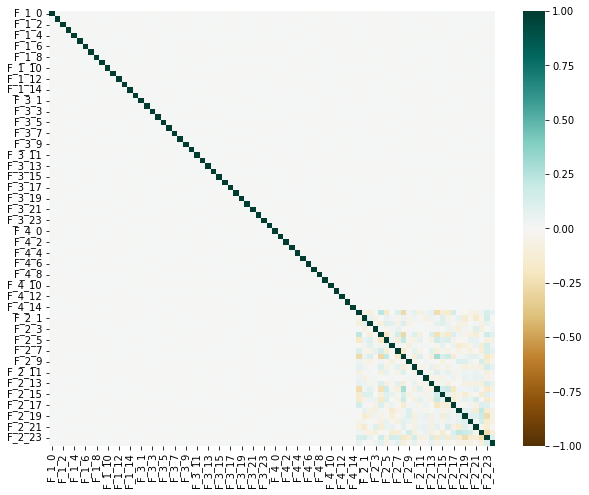

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))

temp = pd.concat([data_f134.isnull().astype(int), data[cols_f2]], axis=1)
corr = temp.corr()
sns.heatmap(corr, vmin=-1, vmax=1,  cmap='BrBG')

plt.show()

# Examine the column distributions

If every cell is randomly NaN with probability $1/55$, then we can view each column as a binomial random variable, distributed as $Binom(1000000, 1/55)$

Per the binomial distribution, this gives:
$$
n = 1000000, \, p=1/55 \\
\mu = np = 18181.81818181 \\
\sigma^2 = np(1-p) = 17851.23966942 \\
\sigma = \sqrt{\sigma^2} = 133.60853142
$$

What do our sample mean and sample variance look like?
- obviously the mean matches exactly 
- the variance/standard deviation seem reasonably close to our hypothesis



In [10]:
data_f134.isna().sum().agg(['mean', 'var', 'std'])

mean   18181.818
var    16094.226
std      126.863
dtype: float64

What does this binomial distribution look like?

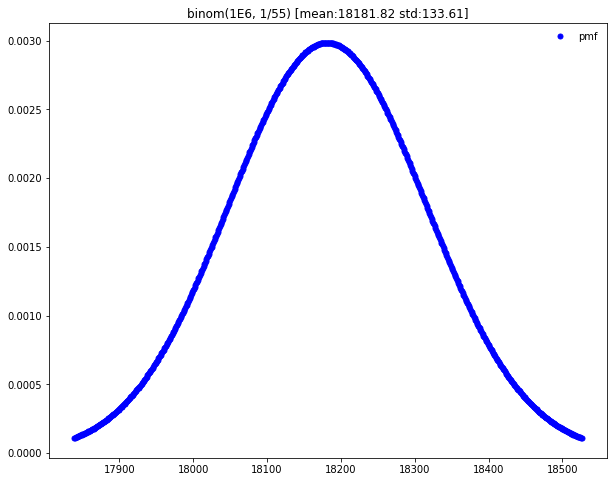

In [11]:
p = 1/55
n = 1E6

rv = binom(n,p)
mean, var = rv.stats()
mean = mean[()]
var = var[()]
std = var**.5

fig, ax = plt.subplots(1, 1, figsize=(10,8))

x = np.arange(binom.ppf(0.005, n, p),
              binom.ppf(0.995, n, p))

ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='pmf')
ax.legend(loc='best', frameon=False)
plt.title(f'binom(1E6, 1/55) [mean:{mean:.2f} std:{std:.2f}]')

plt.show()


Note this looks normal! When $n$ is large, we can approximate a binomial distribution with a normal distribution.

So in our case, we have 55 RVs, which we hypothesize are distributed $N(18181.8181, 17851.2396)$ and standard deviation $133.608$ 

We expect to see the count of missing values by column clustered around the mean, with a spread of a few hundred (since our standard deviation is $\approx 133$)

Let's plot the missing value counts by column, and also look at a histogram. 
- We see the values are indeed clustered around the mean.
- The histogram doesn't look entirely normal, but remember our sample size here is only 55.

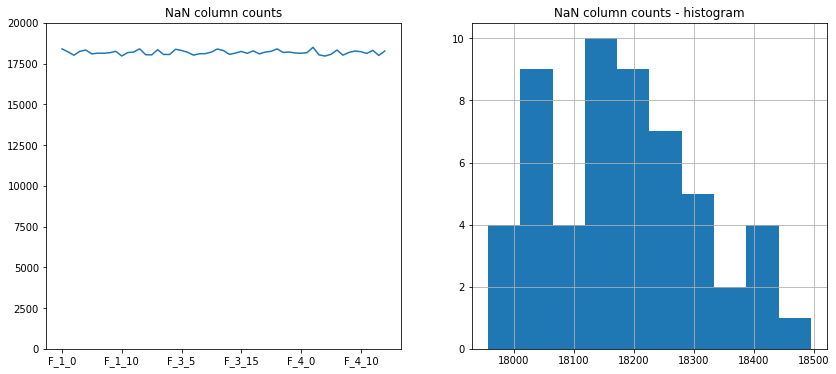

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].set_title("NaN column counts")
data_f134.isna().sum().plot(ax=ax[0], ylim=(0,20000))


ax[1].set_title("NaN column counts - histogram")
na_col_counts = data_f134.isna().sum()
na_col_counts.hist(ax=ax[1])

plt.show()

What else can we do to confirm each column is indeed pulled from a normal distribution?

Well, if it's normal, we expect ~68% of values to fall within 1-sigma, ~95% within 2-sigma, and ~99.7% within 3-sigma. 

Looks pretty close!


In [13]:
na_row_counts = data_f134.isna().sum(axis=0)

for i in range(1,4):
    sigma_lb = mean - i * std
    sigma_ub = mean + i * std
    pct = na_row_counts.between(sigma_lb, sigma_ub).sum() / na_row_counts.size
    print(f"{i}-sigma: {pct:.2f}")


1-sigma: 0.67
2-sigma: 0.98
3-sigma: 1.00


_Conclusion_: the column distributions do indeed appear drawn from the same binomial distribution.

_Notes_: 
- I think we could do a t-test on each of the columns vs the population mean.
- I think we could do a hypothesis test on the sample variance since the binomial distribution is normal for large $n$

# Examine Row Distributions
If we examine row distributions, we expect missing values to be distributed $ binom{55, 1/55) $. Note our sample size is now 1000000.

For small n, the binomial distribution doesn't look anything like a normal distribution. But since we have such a large sample, we can compare our proportions with the distribution.



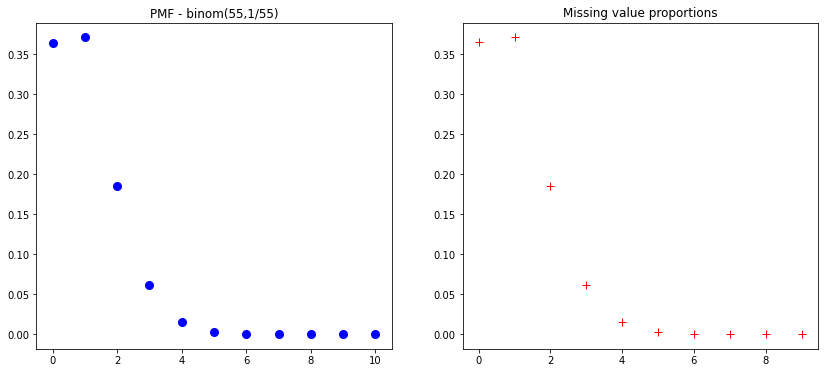

In [14]:
n = 55

fig, ax = plt.subplots(1, 2, figsize=(14,6))

x = np.arange(binom.ppf(0.000000001, n, p),
              binom.ppf(0.999999999, n, p))

# plot the PMF
ax[0].plot(x, binom.pmf(x, n, p), 'bo', ms=8)
ax[0].set_title("PMF - binom(55,1/55)")

# plot the sample proportions
proportions = data.isnull().sum(axis=1).value_counts() / 1E6
ax[1].plot(proportions, 'r+', ms=8)
ax[1].set_title("Missing value proportions")
plt.show()

Looks like a perfect match!

Conclusions:
- Missing values appear uncorrelated with each other
- Column distributions match expectations
- Row distributions match expections
- Values are missing completely at random in F1,F3,F4 column groups, with probability $1/55$

# Why does this matter? Testing!

So why does this matter? Well, if values are missing completely at random, perhaps we can use the rows with no missing values to synthesis our own test data for imputation. 

And since we know what the values actually are, we can use the test metric to evaluate our imputation without having to submit to the competition.

Also, if using a subset of the data is predictive of the LB score, then our training/evaluation can go faster.

So the basic idea is:
- use the ~365000 rows with no missing values
- randomly generate a set of missing values 
- run a couple of imputation techniques on this synthetic data
- is the delta in performance reflective of the delta in performance on the full dataset / leaderboard?


In [15]:
def make_training(df, n, p, random_state):
    # first find all rows with *no* NaN; sample n rows
    df = df[~df.isnull().any(axis=1)]
    if n > 0:
        df = df.sample(n=n, random_state=random_state)
    
    # random mask of NaN locations; only cols F_1*, F_3*, F_4*
    mask = np.random.random(df[cols_f134].shape) < p
    df_na = df[cols_f134].mask(mask)

    # put it back together with F_2*
    df_na = pd.concat([df_na[cols_f1], df[cols_f2], df_na[cols_f3], df_na[cols_f4]], axis=1)
    return df, df_na, df_na.isna().sum().sum()

def rmse(df1, df2, n):
    sse = (df1.to_numpy() - df2.to_numpy())**2
    return (sse.sum()/n)**0.5


## Mean Imputer

Here we run a sklearn SimpleImputer. I've tested this in the competition with the full dataset
- __LB=1.41613__

RMSE on our synthetic test set is close!

In [16]:
%%time

train, train_na, na_count = make_training(data, -1, p, RANDOM_STATE)
imputer = SimpleImputer(strategy="mean")
train_na[:] = imputer.fit_transform(train_na)
print(f'RMSE={rmse(train, train_na, na_count)}')

RMSE=1.4115537025905014
CPU times: user 8.1 s, sys: 1.41 s, total: 9.51 s
Wall time: 9.46 s


## Iterative Imputer

Here we run sklearn IterativeImputer, restricting to 3 iterations. I've also tested this on the leaderboard:
- __LB=0.99623__

Once again, RMSE on the synthetic test data is close!

In [17]:
%%time

train, train_na, na_count = make_training(data, -1, p, RANDOM_STATE)
imputer = IterativeImputer(verbose=2, max_iter=3, random_state=RANDOM_STATE)
train_na[:] = imputer.fit_transform(train_na)
print(f'RMSE={rmse(train, train_na, na_count)}')

[IterativeImputer] Completing matrix with shape (364774, 80)
[IterativeImputer] Ending imputation round 1/3, elapsed time 262.09
[IterativeImputer] Change: 38.36269199934545, scaled tolerance: 0.029931176 
[IterativeImputer] Ending imputation round 2/3, elapsed time 523.10
[IterativeImputer] Change: 10.308020460110583, scaled tolerance: 0.029931176 
[IterativeImputer] Ending imputation round 3/3, elapsed time 784.42
[IterativeImputer] Change: 5.273480070513902, scaled tolerance: 0.029931176 


/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


RMSE=0.9997763927289162
CPU times: user 36min 12s, sys: 6min 18s, total: 42min 31s
Wall time: 13min 14s


## Variability

Perhaps we just got lucky. Here we'll take 3 folds of 200,000 records from the available data, and compare RMSE of all 3.

Results seem pretty pretty consistent. Seems promising.

In [18]:
imputer = IterativeImputer(verbose=2, max_iter=3, random_state=RANDOM_STATE)
rmses = []
for i in range(3):
    train, train_na, na_count = make_training(data, 200000, p, RANDOM_STATE)
    train_na[:] = imputer.fit_transform(train_na)
    rmses.append(rmse(train, train_na, na_count))
    print(f'RMSE={rmses[i]}')
print(f'RMSE mean over folds: {np.mean(rmses)}')

[IterativeImputer] Completing matrix with shape (200000, 80)
[IterativeImputer] Ending imputation round 1/3, elapsed time 141.67
[IterativeImputer] Change: 21.5835593329288, scaled tolerance: 0.029931176 
[IterativeImputer] Ending imputation round 2/3, elapsed time 282.33
[IterativeImputer] Change: 7.726225765171117, scaled tolerance: 0.029931176 
[IterativeImputer] Ending imputation round 3/3, elapsed time 423.99
[IterativeImputer] Change: 2.712997717374159, scaled tolerance: 0.029931176 


/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


RMSE=0.984448841585532
[IterativeImputer] Completing matrix with shape (200000, 80)
[IterativeImputer] Ending imputation round 1/3, elapsed time 141.27
[IterativeImputer] Change: 27.75915955380318, scaled tolerance: 0.029931176 
[IterativeImputer] Ending imputation round 2/3, elapsed time 281.98
[IterativeImputer] Change: 9.071244163754972, scaled tolerance: 0.029931176 
[IterativeImputer] Ending imputation round 3/3, elapsed time 422.96
[IterativeImputer] Change: 3.425432806078268, scaled tolerance: 0.029931176 


/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


RMSE=0.9915785339406507
[IterativeImputer] Completing matrix with shape (200000, 80)
[IterativeImputer] Ending imputation round 1/3, elapsed time 141.76
[IterativeImputer] Change: 28.086467057053916, scaled tolerance: 0.029931176 
[IterativeImputer] Ending imputation round 2/3, elapsed time 283.32
[IterativeImputer] Change: 8.104075394288934, scaled tolerance: 0.029931176 
[IterativeImputer] Ending imputation round 3/3, elapsed time 424.21
[IterativeImputer] Change: 2.901162118272516, scaled tolerance: 0.029931176 


/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


RMSE=0.9932412325031404
RMSE mean over folds: 0.9897562026764412


# Conclusions

- Values are missing completely at random in column groups F1, F3, F4, with probability $1/55$
- We can create synthetic test data by randomizing missing values in the complete records of the full dataset
- This synthetic test data produces evaluation results that seem a good proxy for the full dataset results on the leaderboard

